### Simulation: Masternode Yield Farming

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import Image
cwd =  os.getcwd().replace("notebooks/simulation","")
os.chdir(cwd)

from python.dev.helper import Helper

from python.dev.simulation import SimulationOrchestrator
from python.dev.simulation import EventQueue
from python.dev.simulation import EventExecutor
from python.dev.simulation.batch import ActionBatch
from python.dev.simulation.batch import MergeBatch

from python.dev.agent import TokenAgent
from python.dev.agent import LPTokenAgent
from python.dev.agent import UserAgent

from python.dev.action import MintAction
from python.dev.action import DepositAction
from python.dev.action import LPDepositChainAction
from python.dev.action import DepositChainAction
from python.dev.action import WithdrawChainAction
from python.dev.action import WithdrawAction
from python.dev.action import SwapAction
from python.dev.event import Mint
from python.dev.event import Deposit
from python.dev.event import Withdraw
from python.dev.event import Swap

from python.dev.math.model import TokenDeltaModel
from python.dev.math.model import TimeDeltaModel
from python.dev.math.model import ModelQueue

from python.dev.lp import LiquidityPool
from python.dev.lp.event import LPEvent
from python.dev.lp.event import MintLPEvent
from python.dev.lp.event import DepositLPEvent
from python.dev.lp.event import SwapLPEvent

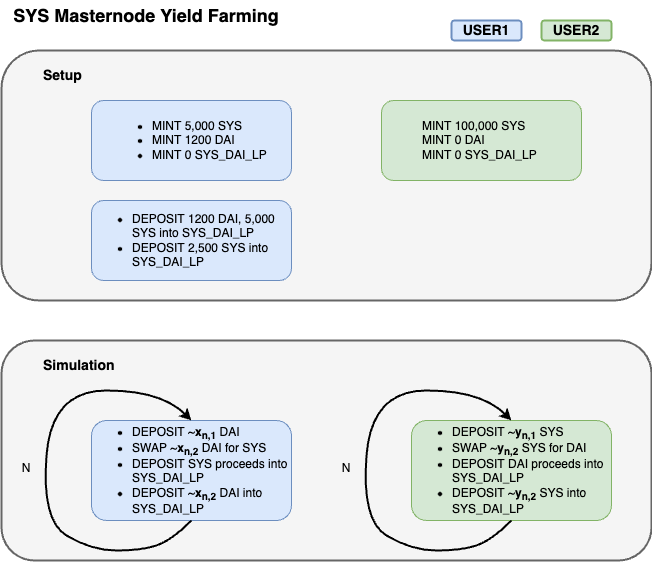

In [2]:
Image("images/jupyter/tutorials/masternode_nft.png", width = 600, height = 600)

### Load Data

In [3]:
daosys_proj = pd.read_csv('notebooks/resources/daosys_proj.csv')

### Initialize Agents

In [4]:
USER1 = UserAgent('USER1')
USER2 = UserAgent('USER2')

SYS = TokenAgent('SYS')
DAI = TokenAgent('DAI')

SYS_DAI_LP = LiquidityPool('SYS/DAI', USER1, SYS, DAI)
SYS_DAI = LPTokenAgent('SYS_DAI_LP', SYS_DAI_LP)

### Mint Tokens

In [5]:
apy = 0.1
t_delta = 109*24*3600
#N_RUNS = len(daosys_proj)
N_RUNS = 25

In [6]:
SYS_mint1 = Mint(5000, apy, True)
DAI_mint1 = Mint(5000, apy, True)
SYS_DAI_LP_mint1 = Mint(0, apy, True)

SYS_mint2 = Mint(100000, apy, True)
DAI_mint2 = Mint(0, apy, True)
SYS_mint3 = Mint(1000, apy, True)
SYS_DAI_LP_mint2 = Mint(0, apy, True)

In [7]:
m_action1 = MintAction(SYS_mint1, SYS, USER1)
m_action2 = MintAction(DAI_mint1, DAI, USER1)
m_action3 = MintAction(SYS_DAI_LP_mint1, SYS_DAI, USER1)

m_action4 = MintAction(SYS_mint2, SYS, USER2)
m_action5 = MintAction(DAI_mint2, DAI, USER2)
m_action6 = MintAction(SYS_DAI_LP_mint2, SYS_DAI, USER2)
m_action7 = MintAction(SYS_mint3, SYS, USER1)

### Setup Actions

In [8]:
sub_withdraw1 = Withdraw(apy, 2500, 0) 
sub_withdraw2 = Withdraw(apy, 2500, 0) 
w_action1 = WithdrawAction(sub_withdraw1, SYS, USER1, SYS_mint1.get_id())
w_action2 = WithdrawAction(sub_withdraw2, DAI, USER1, DAI_mint1.get_id())
d_action1 = LPDepositChainAction(w_action1, w_action2, SYS_DAI, USER1, SYS_DAI_LP_mint1.get_id())

In [9]:
sBatch1 = ActionBatch('SETUP1')
sBatch1.init_action(m_action1)
sBatch1.init_action(m_action2)
sBatch1.init_action(m_action3)
sBatch1.init_action(w_action1)
sBatch1.init_action(w_action2)
sBatch1.init_action(d_action1)
sBatch1.inspect()

setup_batch1 = sBatch1.generate()

** SETUP1 INIT BATCH **
USER1 MINTs 5000.00 SYS 
USER1 MINTs 5000.00 DAI 
USER1 MINTs 0.00 SYS_DAI_LP 
USER1 WITHDRAWs SYS 
USER1 WITHDRAWs DAI 
USER1 DEPOSITs SYS and DAI proceeds into SYS_DAI_LP


In [10]:
sBatch2 = ActionBatch('SETUP2')
sBatch2.init_action(m_action4)
sBatch2.init_action(m_action5)
sBatch2.init_action(m_action6)
sBatch2.init_action(m_action7)
sBatch2.inspect()

setup_batch2 = sBatch2.generate()

** SETUP2 INIT BATCH **
USER2 MINTs 100000.00 SYS 
USER2 MINTs 0.00 DAI 
USER2 MINTs 0.00 SYS_DAI_LP 
USER1 MINTs 1000.00 SYS 


### Batchset 1

In [11]:
deposit_obj1 = ModelQueue().apply(daosys_proj['mn_nsys'].values, N_RUNS)
swap_obj1 = ModelQueue().apply(daosys_proj['mn_nsys'].values/2, N_RUNS)
swap_obj2 = ModelQueue().apply(daosys_proj['mn_nsys'].values/2, N_RUNS)
t_delta_model = TimeDeltaModel().apply(p = 0.00001, n = N_RUNS)
t_delta_obj1 = ModelQueue().apply(t_delta_model)
t_delta_obj2 = ModelQueue().apply(t_delta_model)

#t_delta_obj1 = t_delta
#t_delta_obj2 = t_delta
t_delta = 3600*24

In [12]:
deposit1 = Deposit(apy, deposit_obj1, t_delta) 
sub_withdraw1 = Withdraw(apy, swap_obj1, 0)
sub_deposit1 = Deposit(apy, swap_obj2, t_delta)
withdraw1 = Withdraw(apy, 2500, 0) 

In [13]:
# Deposit 5000 SYS
d_action2 = DepositAction(deposit1, SYS, USER2, SYS_mint2.get_id())

# Swap 2500 SYS for DAI
sub_w_action1 = WithdrawAction(sub_withdraw1, SYS, USER2, SYS_mint2.get_id())
sub_d_action1 = DepositAction(sub_deposit1, DAI, USER2, DAI_mint2.get_id())
s_action1 = SwapAction(sub_w_action1, sub_d_action1)

# Withdraw DAI proceeds and 2500 SYS
w_action3 = WithdrawChainAction(s_action1, DAI, USER2, DAI_mint2.get_id())
w_action4 = WithdrawAction(withdraw1, SYS, USER2, SYS_mint2.get_id())

# Deposit withdrawn DAI and SYS in LP
d_action3 = LPDepositChainAction(w_action3, w_action4, SYS_DAI, USER1, SYS_DAI_LP_mint2.get_id())

In [14]:
aBatch1 = ActionBatch('RUN1', N_RUNS)
aBatch1.add_action(d_action2)
aBatch1.add_action(s_action1)
aBatch1.add_action(w_action3)
aBatch1.add_action(w_action4)
aBatch1.add_action(d_action3)
aBatch1.inspect()

action_batch1 = aBatch1.generate()

** RUN1 ACTION BATCH **
USER2 DEPOSITs SYS 
USER2 SWAPs SYS for DAI 
USER2 WITHDRAWs DAI proceeds
USER2 WITHDRAWs SYS 
USER1 DEPOSITs DAI and SYS proceeds into SYS_DAI_LP

 ** REPEAT BATCH ** 
 25 times

 ** RUNTIME for 1st BATCH ** 
86400 seconds


### Batchset 2

In [15]:
r_deposit_obj = ModelQueue().apply(np.random.normal(50, 5, N_RUNS))
r_withdraw_obj = ModelQueue().apply(np.random.normal(25, 5, N_RUNS))

r_swap_model = np.random.normal(25, 5, N_RUNS)
r_sub_swap_obj1 = ModelQueue().apply(r_swap_model)
r_sub_swap_obj2 = ModelQueue().apply(r_swap_model)

t_delta_model = TimeDeltaModel().apply(p = 0.00001, n = N_RUNS)
t_delta_obj3 = ModelQueue().apply(t_delta_model)
t_delta_obj4 = ModelQueue().apply(t_delta_model)

#t_delta_obj3 = t_delta
#t_delta_obj4 = t_delta

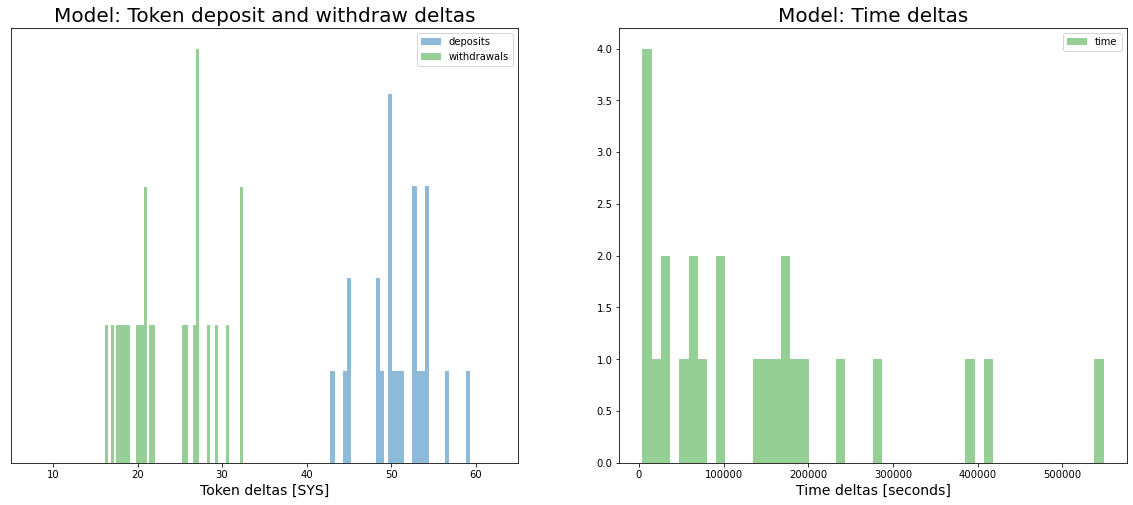

In [16]:
import seaborn as sns
fig, (dist1_ax, dist2_ax) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(20, 8))

r_obj1 = np.random.normal(50, 5, N_RUNS)
r_obj2 = np.random.normal(25, 5, N_RUNS)

blue, _, red = sns.color_palette()[:3]
dist1_ax.hist(r_obj1, 50, color=blue, density=True, alpha=0.5, lw=0, label='deposits');
dist1_ax.hist(r_obj2, 50, color=red, density=True, alpha=0.5, lw=0, label='withdrawals');
dist1_ax.set_xlim(left=0)
dist1_ax.set_xlabel('Token deltas [SYS]', fontsize=14)
dist1_ax.set_yticks([])
dist1_ax.set_xlim(5, 65);
dist1_ax.set_title("Model: Token deposit and withdraw deltas", fontsize=20);
dist1_ax.legend(loc='upper right');

dist2_ax.hist(t_delta_model, 50, color=red, alpha=0.5, lw=0, label='time');
dist2_ax.set_xlabel('Time deltas [seconds]', fontsize=14);
dist2_ax.set_title("Model: Time deltas", fontsize=20);
dist2_ax.legend();

In [17]:
deposit2 = Deposit(apy, r_deposit_obj, t_delta_obj3) 
sub_withdraw2 = Withdraw(apy, r_sub_swap_obj1, 0)
sub_deposit2 = Deposit(apy, r_sub_swap_obj2, t_delta_obj4)
withdraw2 = Withdraw(apy, r_withdraw_obj, 0) 

In [18]:
# Deposit 50 SYS
d_action4 = DepositAction(deposit2, SYS, USER1, SYS_mint1.get_id())

# Swap 2500 SYS for DAI
sub_w_action2 = WithdrawAction(sub_withdraw2, SYS, USER1, SYS_mint1.get_id())
sub_d_action2 = DepositAction(sub_deposit2, DAI, USER1, DAI_mint1.get_id())
s_action2 = SwapAction(sub_w_action2, sub_d_action2)

# Withdraw DAI proceeds and 2500 SYS
w_action5 = WithdrawChainAction(s_action2, DAI, USER1, DAI_mint1.get_id())
w_action6 = WithdrawAction(withdraw2, SYS, USER1, SYS_mint1.get_id())

# Deposit withdrawn DAI and SYS in LP
d_action5 = LPDepositChainAction(w_action5, w_action6, SYS_DAI, USER1, SYS_DAI_LP_mint1.get_id())

In [19]:
aBatch2 = ActionBatch('RUN2', N_RUNS)
aBatch2.add_action(d_action4)
aBatch2.add_action(s_action2)
aBatch2.add_action(w_action5)
aBatch2.add_action(w_action6)
aBatch2.add_action(d_action5)
aBatch2.inspect()

action_batch2 = aBatch2.generate()

** RUN2 ACTION BATCH **
USER1 DEPOSITs SYS 
USER1 SWAPs SYS for DAI 
USER1 WITHDRAWs DAI proceeds
USER1 WITHDRAWs SYS 
USER1 DEPOSITs DAI and SYS proceeds into SYS_DAI_LP

 ** REPEAT BATCH ** 
 25 times

 ** RUNTIME for 1st BATCH ** 
35228 seconds


### Setup event queue

In [20]:
q = EventQueue()
q.add_setup_batch(setup_batch1)
q.add_setup_batch(setup_batch2)
q.add_action_batch(action_batch1)
q.add_action_batch(action_batch2)
q.freeze()

all_batches = q.get_all_batches()

### Execute events

In [21]:
orchestrator = SimulationOrchestrator(verbose = False)
executor = EventExecutor(q, orchestrator)
executor.run()

In [22]:
# orchestrator.print_logs()

### Analyze

In [23]:
tSYS = SYS.get_token()
tDAI = DAI.get_token()
tSYS_DAI = SYS_DAI.get_token()

SYS_addr1 = SYS.get_address(SYS_mint1.get_id())
DAI_addr1 = DAI.get_address(DAI_mint1.get_id())
SYS_DAI_addr1 = SYS_DAI.get_address(SYS_DAI_LP_mint1.get_id())

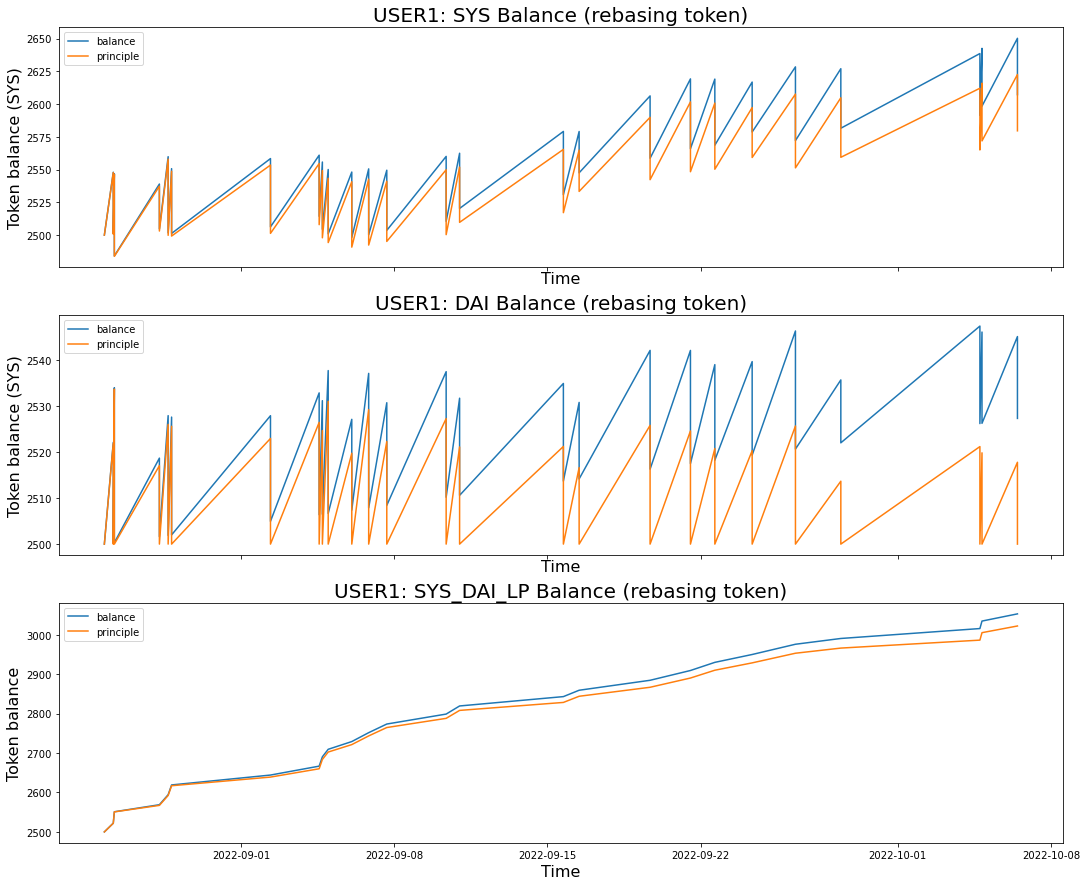

In [24]:
SYS_states1 = tSYS.get_state_series(SYS_addr1)
principle = SYS_states1.get_principle() 
balance = SYS_states1.get_balance() 
tSamp = SYS_states1.get_tstamp()  

fig, (SYS_ax, DAI_ax, SYS_DAI_ax) = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=(18, 15))

SYS_ax.plot(tSamp[1:], balance[1:], label='balance') 
SYS_ax.plot(tSamp[1:], principle[1:], label='principle') 
SYS_ax.set_title("USER1: SYS Balance (rebasing token)", fontsize=20)
SYS_ax.set_ylabel("Token balance (SYS)", fontsize=16)
SYS_ax.set_xlabel('Time', fontsize=16)
SYS_ax.legend()

DAI_states1 = tDAI.get_state_series(DAI_addr1)
principle = DAI_states1.get_principle() 
balance = DAI_states1.get_balance() 
tSamp = DAI_states1.get_tstamp() 

DAI_ax.plot(tSamp[1:], balance[1:], label='balance') 
DAI_ax.plot(tSamp[1:], principle[1:], label='principle') 
DAI_ax.set_title("USER1: DAI Balance (rebasing token)", fontsize=20)
DAI_ax.set_ylabel("Token balance (SYS)", fontsize=16)
DAI_ax.set_xlabel('Time', fontsize=16)
DAI_ax.legend()

SYS_DAI_states1 = tSYS_DAI.get_state_series(SYS_DAI_addr1)
principle = SYS_DAI_states1.get_principle() 
balance = SYS_DAI_states1.get_balance() 
tSamp = SYS_DAI_states1.get_tstamp() 

principle1 = principle
tSamp1 = tSamp

SYS_DAI_ax.plot(tSamp[1:], balance[1:], label='balance') 
SYS_DAI_ax.plot(tSamp[1:], principle[1:], label='principle') 
SYS_DAI_ax.set_title("USER1: SYS_DAI_LP Balance (rebasing token)", fontsize=20)
SYS_DAI_ax.set_ylabel("Token balance", fontsize=16)
SYS_DAI_ax.set_xlabel('Time', fontsize=16)
SYS_DAI_ax.legend()

In [25]:
SYS_addr2 = SYS.get_address(SYS_mint2.get_id())
DAI_addr2 = DAI.get_address(DAI_mint2.get_id())
SYS_DAI_addr2 = SYS_DAI.get_address(SYS_DAI_LP_mint2.get_id())

In [26]:
SYS_DAI_states2 = tSYS_DAI.get_state_series(SYS_DAI_addr2)
sys_principle = SYS_DAI_states2.get_principle() 
sys_balance = SYS_DAI_states2.get_balance() 
tSamp = SYS_DAI_states2.get_tstamp() 

In [27]:
sys_principle[-10]

41813.02185155616

In [28]:
DAI_states2 = tDAI.get_state_series(DAI_addr2)
dai_principle = DAI_states2.get_principle() 
dai_balance = DAI_states2.get_balance() 
tSamp = DAI_states2.get_tstamp() 

In [29]:
2*dai_balance[-10:]

array([5542.54479036,    0.        , 5542.11804579,    0.        ,
       5541.69136692,    0.        , 5541.26475375,    0.        ,
       5540.83820625,    0.        ])

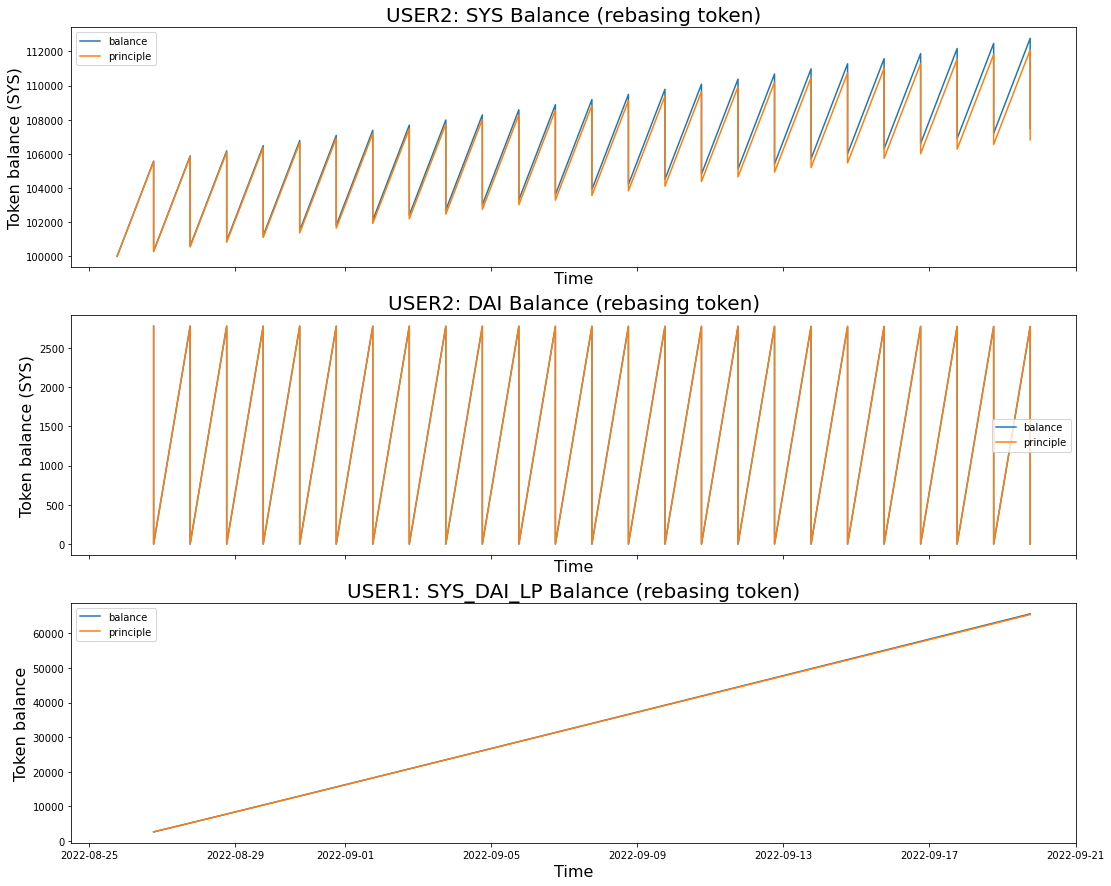

In [30]:
# Analyze Token balances

SYS_states2 = tSYS.get_state_series(SYS_addr2)
principle = SYS_states2.get_principle() 
balance = SYS_states2.get_balance() 
tSamp = SYS_states2.get_tstamp()  

fig, (SYS_ax, DAI_ax, SYS_DAI_ax) = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=(18, 15))

SYS_ax.plot(tSamp, balance, label='balance') 
SYS_ax.plot(tSamp, principle, label='principle') 
SYS_ax.set_title("USER2: SYS Balance (rebasing token)", fontsize=20)
SYS_ax.set_ylabel("Token balance (SYS)", fontsize=16)
SYS_ax.set_xlabel('Time', fontsize=16)
SYS_ax.legend()

DAI_states2 = tDAI.get_state_series(DAI_addr2)
principle = DAI_states2.get_principle() 
balance = DAI_states2.get_balance() 
tSamp = DAI_states2.get_tstamp() 

DAI_ax.plot(tSamp[1:], balance[1:], label='balance') 
DAI_ax.plot(tSamp[1:], principle[1:], label='principle') 
DAI_ax.set_title("USER2: DAI Balance (rebasing token)", fontsize=20)
DAI_ax.set_ylabel("Token balance (SYS)", fontsize=16)
DAI_ax.set_xlabel('Time', fontsize=16)
DAI_ax.legend()

SYS_DAI_states2 = tSYS_DAI.get_state_series(SYS_DAI_addr2)
principle = SYS_DAI_states2.get_principle() 
balance = SYS_DAI_states2.get_balance() 
tSamp = SYS_DAI_states2.get_tstamp() 

SYS_DAI_ax.plot(tSamp[1:], balance[1:], label='balance') 
SYS_DAI_ax.plot(tSamp[1:], principle[1:], label='principle') 
SYS_DAI_ax.set_title("USER1: SYS_DAI_LP Balance (rebasing token)", fontsize=20)
SYS_DAI_ax.set_ylabel("Token balance", fontsize=16)
SYS_DAI_ax.set_xlabel('Time', fontsize=16)
SYS_DAI_ax.legend()

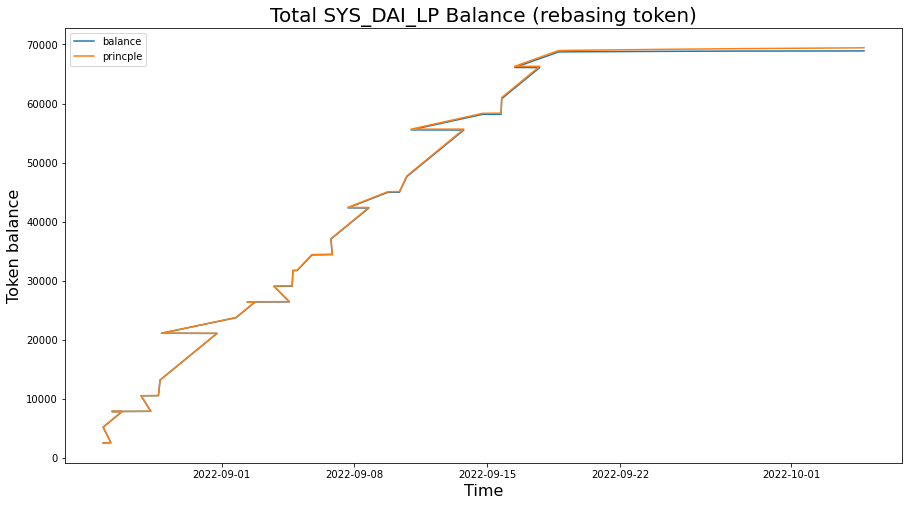

In [31]:
tSamp = SYS_DAI_LP.get_lp_events().get_dates()

utSamp = SYS_DAI_LP.get_lp_events().get_unix_time_stamps()
prices = SYS_DAI_LP.get_lp_events().get_prices()
liquidities = SYS_DAI_LP.get_lp_events().get_liquidity_values()
balances = SYS_DAI_LP.get_lp_events().gen_yield_balances(apy)

fig, (liq_ax) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(15, 8))

liq_ax.plot(tSamp, liquidities, label='balance') 
liq_ax.plot(tSamp, balances, label='princple') 
liq_ax.set_title("Total SYS_DAI_LP Balance (rebasing token)", fontsize=20)
liq_ax.set_ylabel("Token balance", fontsize=16)
liq_ax.set_xlabel('Time', fontsize=16)
liq_ax.legend()